In [550]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Load cleaned data

In [510]:
with open('super_cleaned_mta_data_march.pickle', 'rb') as read_file:
    clean_columns=pickle.load(read_file)

## Analyze weekday vs. weekend entries per day by station

This is a proxy method to deprioritize stations with higher share of tourists

In [512]:
# create dataframe that is copy of cleaned data to work with
clean_columns_tim_analysis = clean_columns.copy()
clean_columns_tim_analysis.head()

,C/A,UNIT,SCP,STATION,start_datetime,end_datetime,interval_on_that_day,entries
1,A002,R051,02-00-00,59 ST,2019-02-23 03:00:00,2019-02-23 07:00:00,04:00:00,11.000
2,A002,R051,02-00-00,59 ST,2019-02-23 07:00:00,2019-02-23 11:00:00,04:00:00,60.000
3,A002,R051,02-00-00,59 ST,2019-02-23 11:00:00,2019-02-23 15:00:00,04:00:00,160.000
4,A002,R051,02-00-00,59 ST,2019-02-23 15:00:00,2019-02-23 19:00:00,04:00:00,290.000
5,A002,R051,02-00-00,59 ST,2019-02-23 19:00:00,2019-02-23 23:00:00,04:00:00,143.000


In [514]:
# adding column with only date so we can group rows by date for analysis of average daily entries
clean_columns_tim_analysis['date_edit'] = (pd.to_datetime(clean_columns_tim['start_datetime'].
                                                          apply(lambda x: x.strftime('%m/%d/%y'))))

# creating function to categorize date as weekday vs. weekend categorization so we can group rows and 
# calc avg daily entries in weekday vs. weekend
def weekday_vs_weekend(dayInt):
    if dayInt in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
        return 'Weekday'
    elif dayInt in ['Saturday', 'Sunday']:
        return 'Weekend'

# add column in dataframe to identify whether row's entries belong to weekday vs. weekend; so that we can 
# sum those entries to weekend vs. weekend for calculating avg entries per day type for that station
# note to self: dt.day_name is datetime method to convert raw datetime data into a weekday name; then use 'apply lambda' to iterate row by row and run previously defined function
clean_columns_tim_analysis['day_of_week'] = clean_columns_tim_analysis['start_datetime'].dt.day_name().apply(lambda x: weekday_vs_weekend(x))

# ask John why doesnt below work... where does .dt go vs. .datetime; whats the natural language behind these
#clean_columns_tim['day_of_week'] = weekday_vs_weekend(clean_columns_tim['start_datetime'].dt.day_name()) 2* df['column']

In [515]:
# create new dataframe 'v2' after finding error - previous data frame each row is a time interval; cannot 
# divide by count of rows to get average daily entries because denominator is # of internals, not # of days
# clean_columns_tim_analysisv2 dataframe groups by date_edit so that each row is a day; entries is sum of entries by intervals in that day
clean_columns_tim_analysisv2 = clean_columns_tim_analysis.groupby(['STATION', 'day_of_week', 'date_edit'], as_index=False).agg({'entries': 'sum'})

In [516]:
clean_columns_timv2

,STATION,day_of_week,date_edit,entries
0,1 AV,Weekday,2019-02-25,18499.494
1,1 AV,Weekday,2019-02-26,19735.741
2,1 AV,Weekday,2019-02-27,20145.491
3,1 AV,Weekday,2019-02-28,20529.490
4,1 AV,Weekday,2019-03-01,21201.484
...,...,...,...,...
13207,ZEREGA AV,Weekend,2019-03-10,813.246
13208,ZEREGA AV,Weekend,2019-03-16,1324.494
13209,ZEREGA AV,Weekend,2019-03-17,992.997
13210,ZEREGA AV,Weekend,2019-03-23,1294.995


In [520]:
# create new dataframe to group station data by day of week - this will allow us to divide entries by count of days
# in order to calculate average entries per day
weekdays_analysis = clean_columns_timv2.groupby(['STATION', 'day_of_week'], as_index=False).agg({'date_edit': 'count', 'entries': 'sum'}).copy()
weekdays_analysis = weekdays_analysis.rename(columns={"date_edit": "count_of_days_in_data"})


In [521]:
weekdays_analysis.head()

,STATION,day_of_week,count_of_days_in_data,entries
0,1 AV,Weekday,25,496698.154
1,1 AV,Weekend,10,23234.723
2,103 ST,Weekday,25,767642.309
3,103 ST,Weekend,10,154625.776
4,103 ST-CORONA,Weekday,25,503205.816


In [523]:
# create column with average entries per day (each station has separate data for weekend vs. weekday)
weekdays_analysis['entries_per_day'] = weekdays_analysis['entries'] / weekdays_analysis['count_of_days_in_data'] 

In [524]:
weekdays_analysis

,STATION,day_of_week,count_of_days_in_data,entries,entries_per_day
0,1 AV,Weekday,25,496698.154,19867.926
1,1 AV,Weekend,10,23234.723,2323.472
2,103 ST,Weekday,25,767642.309,30705.692
3,103 ST,Weekend,10,154625.776,15462.578
4,103 ST-CORONA,Weekday,25,503205.816,20128.233
...,...,...,...,...,...
751,WTC-CORTLANDT,Weekend,10,61923.857,6192.386
752,YORK ST,Weekday,25,306643.667,12265.747
753,YORK ST,Weekend,10,53432.328,5343.233
754,ZEREGA AV,Weekday,25,68441.181,2737.647


In [536]:
# Since stackbar chart in matplotlib requires graphing top vs. bottom stack as top separate series, this
# code is to separate dataframe into two series 

# Get names of stations with highest entries from other analysis (Tyler)
highest_entry_stations = ['34 ST-PENN STA',
 'GRD CNTRL-42 ST',
 '34 ST-HERALD SQ',
 '23 ST',
 '42 ST-PORT AUTH',
 '14 ST-UNION SQ',
 'TIMES SQ-42 ST',
 'FULTON ST',
 '86 ST',
 '125 ST',
 'CANAL ST',
 '59 ST COLUMBUS',
 '59 ST',
 '14 ST',
 '96 ST',
 'CHAMBERS ST',
 'FLUSHING-MAIN',
 '47-50 STS ROCK',
 'JKSN HT-ROOSVLT',
 '50 ST']

# use filter to identify the set of stations we want to pull
#df.loc[df.gender == 'Male', ]
stations_to_graph = weekdays_analysis.loc[(weekdays_analysis['STATION'].isin(list(highest_entry_stations)))]

# separate series for weekday vs. weekend - while making sure to sort by station so both output series are tied
# example filtering code from class: df[df.age > 50].head(4)
stations_to_graph_weekday = stations_to_graph[stations_to_graph.day_of_week == 'Weekday'].sort_values(['STATION'])['entries_per_day']
stations_to_graph_weekend = stations_to_graph[stations_to_graph.day_of_week == 'Weekend'].sort_values(['STATION'])['entries_per_day']

In [537]:
# check that we are graphing 20 stations (should have 40 rows, two datapoints per station)
stations_to_graph.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 18 to 705
Data columns (total 5 columns):
STATION                  40 non-null object
day_of_week              40 non-null object
count_of_days_in_data    40 non-null int64
entries                  40 non-null float64
entries_per_day          40 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.9+ KB


In [538]:
# check it pulled in the right number of stations
len(stations_to_graph['STATION'].unique())

20

['125 ST', '14 ST', '14 ST-UNION SQ', '23 ST', '34 ST-HERALD SQ', '34 ST-PENN STA', '42 ST-PORT AUTH', '47-50 STS ROCK', '50 ST', '59 ST', '59 ST COLUMBUS', '86 ST', '96 ST', 'CANAL ST', 'CHAMBERS ST', 'FLUSHING-MAIN', 'FULTON ST', 'GRD CNTRL-42 ST', 'JKSN HT-ROOSVLT', 'TIMES SQ-42 ST']


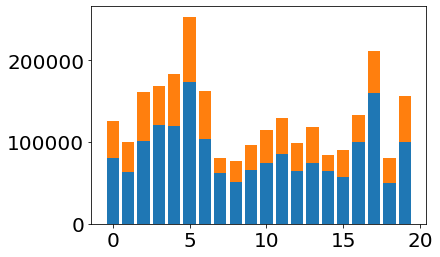

In [539]:
"""
GRAPH #1 - Stack bar of weekday vs. weekend <- decided not to use because visual is not compelling

Sample code below for how to graph stack bar
N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, yerr=menStd)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans, yerr=womenStd)"""

N = len(stations_to_graph_weekday)
ind = np.arange(N)
width = 0.35

p1 = plt.bar(ind, stations_to_graph_weekday)
p2 = plt.bar(ind, stations_to_graph_weekend,bottom=stations_to_graph_weekday.values)
print(sorted(highest_entry_stations))

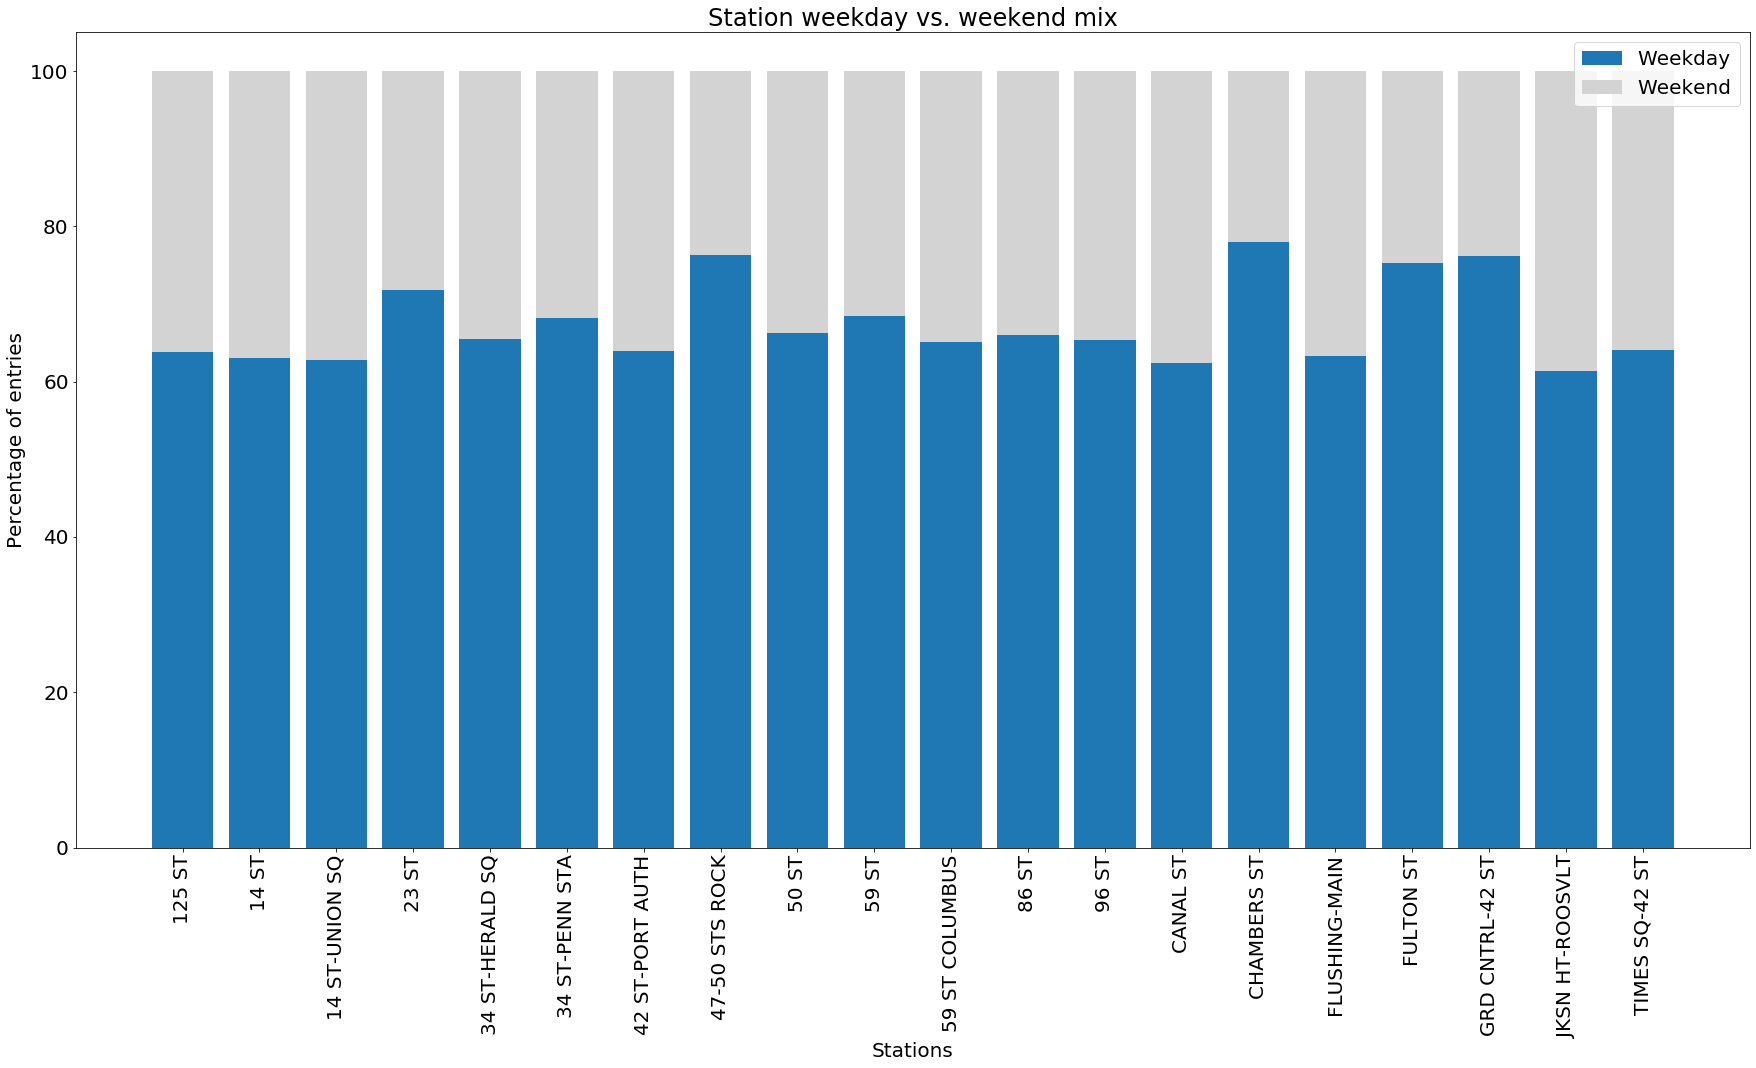

In [565]:
"""
GRAPH #2 - 100% stack bar of weekday vs. weekend <- decided not to use because weekday + weekend entries per 
day as 100% stack has no real world meaning (confusing)

Sample code below for how to create 100% stack bar
# Data
r = [0,1,2,3,4]
raw_data = {'greenBars': [20, 1.5, 7, 10, 5], 'orangeBars': [5, 15, 5, 10, 15],'blueBars': [2, 15, 18, 5, 10]}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['greenBars'], df['orangeBars'], df['blueBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
blueBars = [i / j * 100 for i,j in zip(df['blueBars'], totals)]
 
# plot
barWidth = 0.85
names = ('A','B','C','D','E')
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth)
# Create blue Bars
plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth)
 
# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
 
# Show graphic
plt.show()
"""
# from raw entries per day values to percentage
totals = [i+j for i,j in zip(stations_to_graph_weekday, stations_to_graph_weekend)]
blueBars = [(i / j) * 100 for i,j in zip(stations_to_graph_weekday, totals)]
orangeBars = [(i / j) * 100 for i,j in zip(stations_to_graph_weekend, totals)]

# Custom chart settings
plt.figure(figsize = [30,15]) # [width, height]
plt.title('Station weekday vs. weekend mix')
plt.rcParams.update({'font.size': 20})

# Custom x axis settings
N = len(stations_to_graph_weekday)
ind = np.arange(N)
width = 0.35
names = sorted(highest_entry_stations)
plt.xticks(ind, names, rotation=90)
plt.xlabel('Stations')

# Custom y axis settings
plt.ylabel('Percentage of entries')

# Plot data
plt.bar(ind, blueBars, color='tab:blue', label = 'Weekday')
plt.bar(ind, orangeBars,bottom=blueBars, color = 'lightgray', label = 'Weekend')
plt.legend(loc="upper right")
plt.show()



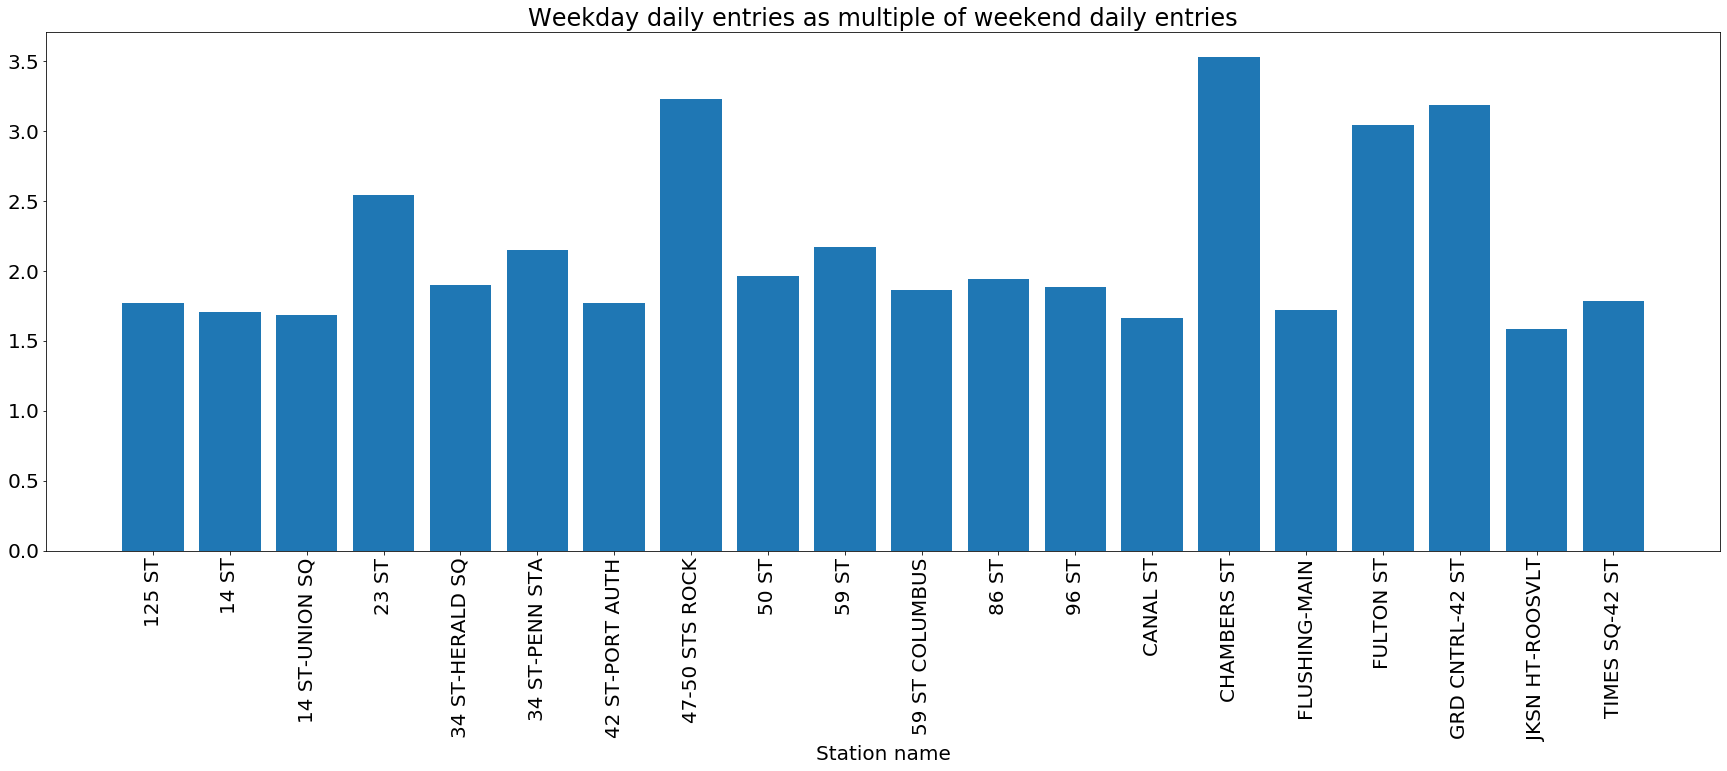

In [569]:
"""
Graph #3 - THIS IS THE CORRECT VERSION. Show weekend as multiple of weekday
"""

# Only need one bar - how many more times is weekday entries per day greater than weekend entries per day
# Note to self: Use zip function to pull data from two separate lists (weekday entries and weekend entries by station) and list comprehension to do the calc
blueBars = [(i / j) for i,j in zip(stations_to_graph_weekday, stations_to_graph_weekend)]

# Custom chart settings
plt.figure(figsize = [30,15]) # [width, height]
plt.title('Weekday daily entries as multiple of weekend daily entries')
plt.rcParams.update({'font.size': 20})

# Custom x axis settings
N = len(stations_to_graph_weekday)
ind = np.arange(N)
width = 0.35
names = sorted(stations_from_tyler)
plt.xticks(ind, names, rotation=90)
plt.xlabel('Station name')

# Plot data
p1 = plt.bar(ind, blueBars, color='tab:blue', label = 'Weekday')
plt.show

# Adjust output image so x-axis labels are not cut off
plt.gcf().subplots_adjust(bottom=0.4)

# Save plot as png
plt.savefig('weekdays_analysis.png', format='png')



## Sanity check vs. high level numbers

Check that total stations counts, total entries counts, top 20 as % of total, and top 20 as multiple of other stations pass sanity check

In [570]:
weekdays_analysis_temp = weekdays_analysis.loc[weekdays_analysis['day_of_week'] == 'Weekday']

In [571]:
weekdays_analysis_temp = weekdays_analysis_temp.sort_values('entries_per_day', ascending=False)

In [572]:
weekdays_analysis_temp.head(20)

,STATION,day_of_week,count_of_days_in_data,entries,entries_per_day
122,34 ST-PENN STA,Weekday,25,4323659.586,172946.383
466,GRD CNTRL-42 ST,Weekday,25,4013858.509,160554.340
92,23 ST,Weekday,25,3020402.688,120816.108
118,34 ST-HERALD SQ,Weekday,25,2999391.034,119975.641
136,42 ST-PORT AUTH,Weekday,25,2602991.003,104119.640
28,14 ST-UNION SQ,Weekday,25,2535798.556,101431.942
452,FULTON ST,Weekday,25,2500050.639,100002.026
704,TIMES SQ-42 ST,Weekday,25,2497387.285,99895.491
220,86 ST,Weekday,25,2140215.853,85608.634
18,125 ST,Weekday,25,2013696.934,80547.877


In [573]:
print(weekdays_analysis_temp['entries_per_day'].iloc[0:20].mean())
print(weekdays_analysis_temp['entries_per_day'].iloc[20:].mean())

89208.7945674812
11480.181411034777


In [574]:
weekdays_analysis_temp['entries'].iloc[0:20].sum() / weekdays_analysis_temp['entries'].sum()

0.30295416104792716

In [575]:
weekdays_analysis_temp

,STATION,day_of_week,count_of_days_in_data,entries,entries_per_day
122,34 ST-PENN STA,Weekday,25,4323659.586,172946.383
466,GRD CNTRL-42 ST,Weekday,25,4013858.509,160554.340
92,23 ST,Weekday,25,3020402.688,120816.108
118,34 ST-HERALD SQ,Weekday,25,2999391.034,119975.641
136,42 ST-PORT AUTH,Weekday,25,2602991.003,104119.640
...,...,...,...,...,...
664,ROCKAWAY PARK B,Weekday,25,16361.718,654.469
296,BEACH 98 ST,Weekday,25,11912.991,476.520
324,BROAD CHANNEL,Weekday,25,8561.489,342.460
282,BEACH 105 ST,Weekday,25,6038.998,241.560


In [576]:
(weekdays_analysis.loc[weekdays_analysis['day_of_week'] == 'Weekday'].
 sort_values('entries_per_day', ascending=False).
 iloc[20:]['entries_per_day'].mean()) / (weekdays_analysis.loc[weekdays_analysis['day_of_week'] == 'Weekend'].
 sort_values('entries_per_day', ascending=False).
 iloc[20:]['entries_per_day'].mean())

2.2016409570799893

In [577]:
(weekdays_analysis.loc[weekdays_analysis['day_of_week'] == 'Weekday'].
 sort_values('entries_per_day', ascending=False).
 iloc[20:]['entries_per_day'].sum()) / (weekdays_analysis.loc[weekdays_analysis['day_of_week'] == 'Weekend'].
 sort_values('entries_per_day', ascending=False).
 iloc[20:]['entries_per_day'].sum())

2.2016409570799893